In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt

In [38]:
%%writefile rhs.c
#include "rebound.h"
void derivatives(struct reb_ode* const ode, double* const yDot, const double* const y, const double t){
    if (ode->r->integrator == REB_INTEGRATOR_BS){
        reb_integrator_bs_update_particles(ode->r, NULL);
    }
    double alpha = 8.397 / 1296000.; // # arcsec/yr to code units (rad/(yr/2pi))

    struct reb_particle p = ode->r->particles[4];
    reb_particle_isub(&p, &ode->r->particles[0]);
    
    double Lx = p.y*p.vz - p.z*p.vy;
    double Ly = p.z*p.vx - p.x*p.vz;
    double Lz = p.x*p.vy - p.y*p.vx;
    
    double L = 1./sqrt(Lx*Lx + Ly*Ly + Lz*Lz);
    Lx *= L;
    Ly *= L;
    Lz *= L;

    double alphaLS = alpha * (Lx*y[0] + Ly*y[1] + Lz*y[2]);
    
    yDot[0] = alphaLS * (Ly*y[2] - Lz*y[1]);
    yDot[1] = alphaLS * (Lz*y[0] - Lx*y[2]);
    yDot[2] = alphaLS * (Lx*y[1] - Ly*y[0]);
}


Overwriting rhs.c


In [39]:
!cp ../src/librebound.so .
!cp ../src/rebound.h .

In [40]:
!gcc -c -O3 -fPIC rhs.c -o rhs.o

In [41]:
!gcc -L. -shared rhs.o -o rhs.so -lrebound 

In [42]:
from ctypes import cdll, byref, c_double
clibrhs = cdll.LoadLibrary("rhs.so")

We first set up our N-body simulation. Note that we are using the Gragg-Bulirsch-Stoer integrator (BS).

In [43]:
try:
    sim = rebound.Simulation("ss.bin")
except:
    sim = rebound.Simulation()
    sim.add(["Sun","Mercury","Venus","Earth","Mars","Jupiter","Saturn","Uranus","Neptune"])
    sim.save("ss.bin")
sim.integrator = "BS"
sim.integrator = "WHFast"
sim.dt = sim.particles[1].P/25.

In [44]:
ode_ho = sim.create_ode(length=3)

In [45]:
eps = 25.19/180*np.pi # approximate current obliquity in radian
spin0 = np.array((0.0,np.sin(eps),np.cos(eps)))
ode_ho.y[0] = spin0[0]
ode_ho.y[1] = spin0[1]
ode_ho.y[2] = spin0[2]
#ode_ho.derivatives = rhs
ode_ho.derivatives = clibrhs.derivatives

In [46]:
times = np.linspace(0.,1e6*np.pi*2.,1000)
obliq = np.zeros((len(times)))

for i, t in enumerate(times):
    sim.integrate(t, exact_finish_time=0)
    times[i] = sim.t
    
    dp = sim.particles[4] - sim.particles[0]
    x = dp.xyz
    v = dp.vxyz
    L = np.cross(x,v)
    L_hat = L / np.sqrt(np.sum(L**2))
    spin = [ode_ho.y[0],ode_ho.y[1],ode_ho.y[2]]
    obliq[i] =  np.arccos(np.dot(L_hat,spin))

KeyboardInterrupt: 

Let's plot the relative energy error over time for both the N-body and the harmonic oscillator integration.

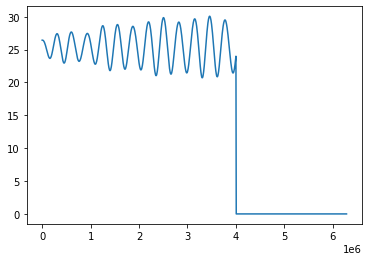

In [48]:
fig, ax = plt.subplots(1,1)
precfreq = 7.599 / 1296000
ax.plot(times,obliq*180/np.pi)
#ax.plot(times,(obliq[0]+ precfreq*times)*180/np.pi)

In [18]:
alpha = 8.397 / 1296000 # arcsec/yr to code units (rad/(yr/2pi))
def rhs(ode, yDot, y, t):
    return
    #ode.contents.update_particles()

    dp = sim.particles[4] - sim.particles[0]
    x = dp.xyz
    v = dp.vxyz
    L = np.cross(x,v)
    L_hat = L / np.sqrt(np.sum(L**2))
    S = np.array((y[0],y[1],y[2]))
    
    yd = -alpha * np.dot(L_hat,S)* np.cross(L_hat, S)
    yDot[0] = yd[0]
    yDot[1] = yd[1]
    yDot[2] = yd[2]    